## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [13]:
print(tf.__version__)

2.0.0-alpha0


[大型翻车现场，升级到tensorflow 2.0，我整个人都不好了](https://cloud.tencent.com/developer/article/1524140)

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(w=0.3):
    w=float(w)
    gamma = float(2)
    alpha = float(4)
    def combined_loss_fixed(y_true,y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        focal_loss=tf.reduce_mean(reduced_fl)
        cross_entropy=K.categorical_crossentropy(y_pred, y_true)
        return w*focal_loss+(1-w)*cross_entropy
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [17]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(w=ce_w), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % str(ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_12 (B (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_13 (B (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_1

Epoch 13/25
50000/50000 [==============================] - 8s 156us/sample - loss: 5.3373 - acc: 0.6973 - val_loss: 8.0216 - val_acc: 0.4987
Epoch 14/25
50000/50000 [==============================] - 8s 152us/sample - loss: 5.1291 - acc: 0.7107 - val_loss: 8.0696 - val_acc: 0.4940
Epoch 15/25
50000/50000 [==============================] - 7s 142us/sample - loss: 4.8878 - acc: 0.7276 - val_loss: 8.0741 - val_acc: 0.4968
Epoch 16/25
50000/50000 [==============================] - 7s 147us/sample - loss: 4.6559 - acc: 0.7449 - val_loss: 8.0579 - val_acc: 0.4902
Epoch 17/25
50000/50000 [==============================] - 7s 141us/sample - loss: 4.4621 - acc: 0.7576 - val_loss: 8.3924 - val_acc: 0.4767
Epoch 18/25
50000/50000 [==============================] - 7s 139us/sample - loss: 4.2647 - acc: 0.7709 - val_loss: 8.5033 - val_acc: 0.4761
Epoch 19/25
50000/50000 [==============================] - 7s 134us/sample - loss: 4.0654 - acc: 0.7838 - val_loss: 8.4291 - val_acc: 0.4831
Epoch 20/25
5

Epoch 1/25
50000/50000 [==============================] - 7s 150us/sample - loss: 8.0056 - acc: 0.3339 - val_loss: 9.0496 - val_acc: 0.1928
Epoch 2/25
50000/50000 [==============================] - 7s 133us/sample - loss: 6.4586 - acc: 0.4506 - val_loss: 7.7108 - val_acc: 0.3430
Epoch 3/25
50000/50000 [==============================] - 7s 135us/sample - loss: 5.9799 - acc: 0.4911 - val_loss: 6.9009 - val_acc: 0.4167
Epoch 4/25
50000/50000 [==============================] - 7s 134us/sample - loss: 5.6521 - acc: 0.5247 - val_loss: 6.5746 - val_acc: 0.4461
Epoch 5/25
50000/50000 [==============================] - 7s 134us/sample - loss: 5.3989 - acc: 0.5451 - val_loss: 6.2269 - val_acc: 0.4715
Epoch 6/25
50000/50000 [==============================] - 7s 134us/sample - loss: 5.1666 - acc: 0.5688 - val_loss: 6.0043 - val_acc: 0.4797
Epoch 7/25
50000/50000 [==============================] - 7s 133us/sample - loss: 4.9498 - acc: 0.5861 - val_loss: 6.1014 - val_acc: 0.4711
Epoch 8/25
50000/500

50000/50000 [==============================] - 7s 133us/sample - loss: 1.1564 - acc: 0.8031 - val_loss: 4.5360 - val_acc: 0.4757
Epoch 24/25
50000/50000 [==============================] - 7s 134us/sample - loss: 1.0645 - acc: 0.8194 - val_loss: 4.8001 - val_acc: 0.4586
Epoch 25/25
50000/50000 [==============================] - 7s 136us/sample - loss: 0.9909 - acc: 0.8282 - val_loss: 4.7666 - val_acc: 0.4776


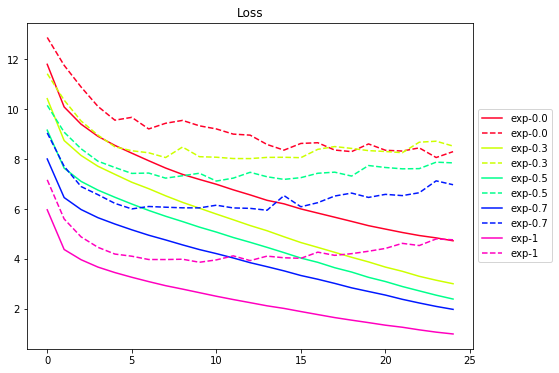

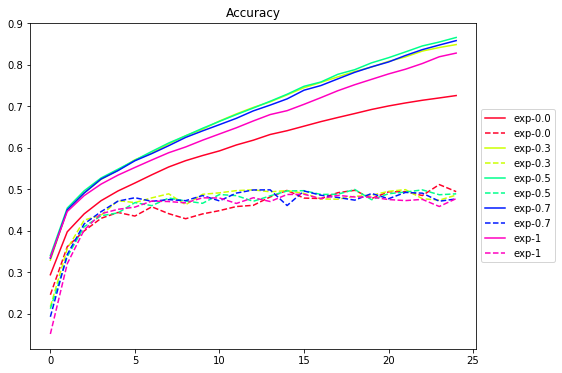

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()